In [17]:
from __future__ import print_function, division
import os
import torch
import os
import torch
import pandas as pd
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
from tensorflow.python.client import device_lib; device_lib.list_local_devices()

In [18]:
class DenoisingDataset(Dataset):

    def __init__(self, data_dir, transform=None, train=True):
        self.train= train 
        self.x_path = os.path.join(data_dir, 'clean')
        self.y_path = os.path.join(data_dir, 'distorted')
        self.x_test_path = os.path.join(data_dir, 'test_distorted')
        self.x_files_paths = glob.glob(os.path.join(self.x_path, '*.jpg'))
        self.y_files_paths = glob.glob(os.path.join(self.y_path, '*.jpg'))
        self.x_test_files_paths = glob.glob(os.path.join(self.x_test_path, '*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.x_files_paths)

    def __getitem__(self, idx):
        if self.train: 
            x_img_name, y_img_name =  self.x_files_paths[idx], self.y_files_paths[idx]
            x_image, y_image = io.imread(x_img_name), io.imread(y_img_name)
            sample = {'x': x_image, 'y': y_image}
        else:
            x_test_img_name =  self.x_test_files_paths[idx]
            x_test_image = io.imread(x_test_img_name)
            sample = {'x_test': x_test_image}
            
        if self.transform:
            sample = self.transform(sample)

        return sample

In [19]:
data_path = os.path.join(os.getcwd(), 'data')

In [34]:
train_dataset = DenoisingDataset(data_path, 
                                 transform=transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda x: x.flatten())
                                ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [30]:
dataset.y_files_paths[0]

'/home/michal/Studia/2_semester/SolPushinRep/nn2019/3_kaggle_denoising/data/distorted/448.jpg'

In [31]:
def show_img(image):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

0 (48, 48, 3) (48, 48, 3)


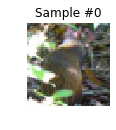

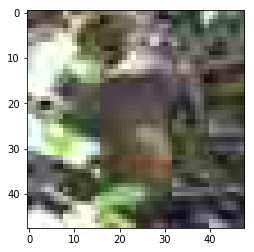

1 (48, 48, 3) (48, 48, 3)


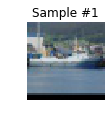

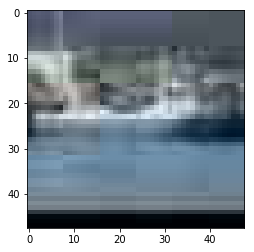

2 (48, 48, 3) (48, 48, 3)


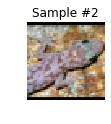

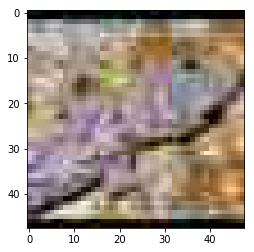

3 (48, 48, 3) (48, 48, 3)


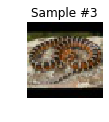

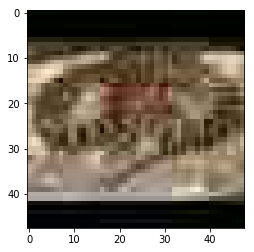

In [32]:
fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]

    print(i, sample['x'].shape, sample['y'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_img(sample['x'])
    show_img(sample['y'])

    if i == 3:
        plt.show()
        break

In [36]:
batch_size = 32

In [37]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [38]:
class AutoEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim, image_size):
        
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(image_size, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, self.latent_dim),
          ) 
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, image_size),
            nn.Sigmoid()
          )
        
    def decode(self, z):
        return self.decoder(z)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        en_out = self.encode(x)
        de_out = self.decode(en_out)
        return en_out, de_out

In [ ]:
# Hyper Parameters
epochs = 10
lr = 0.005 
n_plots = 5

# prepare original data for plotting
view_data = train_data.train_dataset[:n_plots].view(-1, 48*48).type(torch.FloatTensor) / 255.

autoencoder = AutoEncoder(latent_dim=3)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = loss = nn.MSELoss()


for epoch in range(epochs):
    for step, (x, y) in enumerate(train_loader):

        encoded, decoded = autoencoder(x) 

        loss = loss_func(decoded, x) 
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 500 == 0 and epoch in [0, 5, epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            plot_digits(view_data, decoded_data)


In [40]:
test_dataset = DenoisingDataset(data_path, 
                                train=False,
                                transform=transforms.Compose([
                                   torchvision.transforms.ToTensor()
                                   torchvision.transforms.Lambda(lambda x: x.flatten())
                                ]))

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
decoded_samples = []

for step, x in enumerate(test_loader):
    
    en_x, de_x = autoencoder(x)
    decoded_samples.append(de_x.detach().numpy())
    # encode the points into the latent space and save for later estimation
    
sampled_z = np.concatenate(samples, axis=0)